In [1256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# sklearn
# fuzzywuzzy
# scipy
# arules

In [1257]:
data_path = 'survey_results.csv'
data_raw_df= pd.read_csv(data_path)
data_raw_df.head(1)

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [1258]:
data_raw_df.shape

(50, 13)

In [1259]:
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

In [1260]:
data_raw_df.describe()

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
count,50,50,50,50,49,50,49,50,50,50,50,50,17
unique,4,3,3,3,37,3,23,16,5,3,4,2,17
top,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels,Dashboard,500-1000,Only with professional help,500-1000,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
freq,41,32,36,38,5,37,8,11,19,26,21,33,1


In [1261]:
null = pd.DataFrame({'Null Values':data_raw_df.isnull().sum(),'Percentage Null Values':data_raw_df.isnull().sum()*100/len(data_raw_df)})
null

,Null Values,Percentage Null Values
Which age group do you belong to?,0,0.0
What is your gender?,0,0.0
Which category do you currently belong to?,0,0.0
Which of the following best describes you?,0,0.0
Which of these factors are important to you when deciding which car to purchase?,1,2.0
How likely are you to opt for customised vehicle if there were no extra charges?,0,0.0
"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?",1,2.0
"Which of the following interior components would you choose to customise (texture, layout, size, etc)?",0,0.0
How much are you willing to spend on car customisation if surcharges are applicable?,0,0.0
Are you interested in designing your own components to personalise your car?,0,0.0


In [1262]:
for column_name in data_raw_df.columns:
    print(column_name)
    print(data_raw_df[column_name].unique())
    print("")

Which age group do you belong to?
['20-30' '51-60' '41-50' '31-40']

What is your gender?
['Male' 'Female' 'Prefer not to say']

Which category do you currently belong to?
['Do not own a car, but planning to purchase in future'
 'Own more than one car' 'Own a car']

Which of the following best describes you?
['Single' 'Married with children' 'Married with no children']

Which of these factors are important to you when deciding which car to purchase?
['Price;Functionality;Size;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Sustainability/environment considerations'
 'Aesthetics;Functionality;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainability/environment considerations'
 'Price;Brand name;Aesthetics;Technological features;Functionality'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size'
 'Price;Technological features;Functionality'
 'Price;Br

In [1263]:
# Data Cleaning
# To change the keys (column names) of multiple columns:
data_mod_df = data_raw_df.copy()
data_mod_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership_status",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customsied_vehicle_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components_customisation",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components_customisation",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customisation_spend",
                            "Are you interested in designing your own components to personalise your car? ": "customisation_interest",
                            "How much are you willing to pay for the personalised design? ": "personalised_design_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "3D_design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [1264]:
data_mod_df['personalised_design_spend'] = data_mod_df.apply(lambda row: 'under 500' if row['personalised_design_spend'] == '100-500' else row['personalised_design_spend'], axis=1)
data_mod_df['customisation_spend'] = data_mod_df.apply(lambda row: 'under 500' if row['customisation_spend'] == '100-500' else row['customisation_spend'], axis=1)

In [1265]:
data_mod_df['purchase_factors'] = data_mod_df['purchase_factors'].str.split(';')
data_mod_df['exterior_components_customisation'] = data_mod_df['exterior_components_customisation'].str.split(';')
data_mod_df['interior_components_customisation'] = data_mod_df['interior_components_customisation'].str.split(';')
data_mod_df.head()

,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Functionality, Size, Customisable opti...",Very likely,[Grilles],[Centre compartment],under 500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN
1,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Likely,"[Wheels, Grilles, Headlights, Side mirrors]",[Centre compartment],under 500,Only with professional help,under 500,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
2,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Aesthetics, Functionality, Customisable options]",Very likely,"[Wheels, Grilles, Headlights, Side mirrors]","[Steering wheel, Dashboard]",500-1000,Yes,500-1000,"Yes, I can design on my own",NaN
3,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Side mirrors, Bu...","[Steering wheel, Centre compartment, Door hand...",under 500,Yes,under 500,"No, I would need a designer to model my sketch",NaN
4,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Bumpers]","[Steering wheel, Centre compartment]",over 1000,Only with professional help,over 1000,"No, I would need a designer to model my sketch",Sg flag/ colour related car paint


In [1266]:
purchase_factor_counts = data_mod_df['purchase_factors'].explode().value_counts()
interior_components_counts = data_mod_df['interior_components_customisation'].explode().value_counts()
exterior_components_counts = data_mod_df['exterior_components_customisation'].explode().value_counts()

In [1267]:
def find_unique_values(df, column_name, delmiter):
    unique_values = []
    for values in df[column_name].unique():
        if values is np.nan:
            continue
        _ = values.split(delmiter)
        for value in _:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values

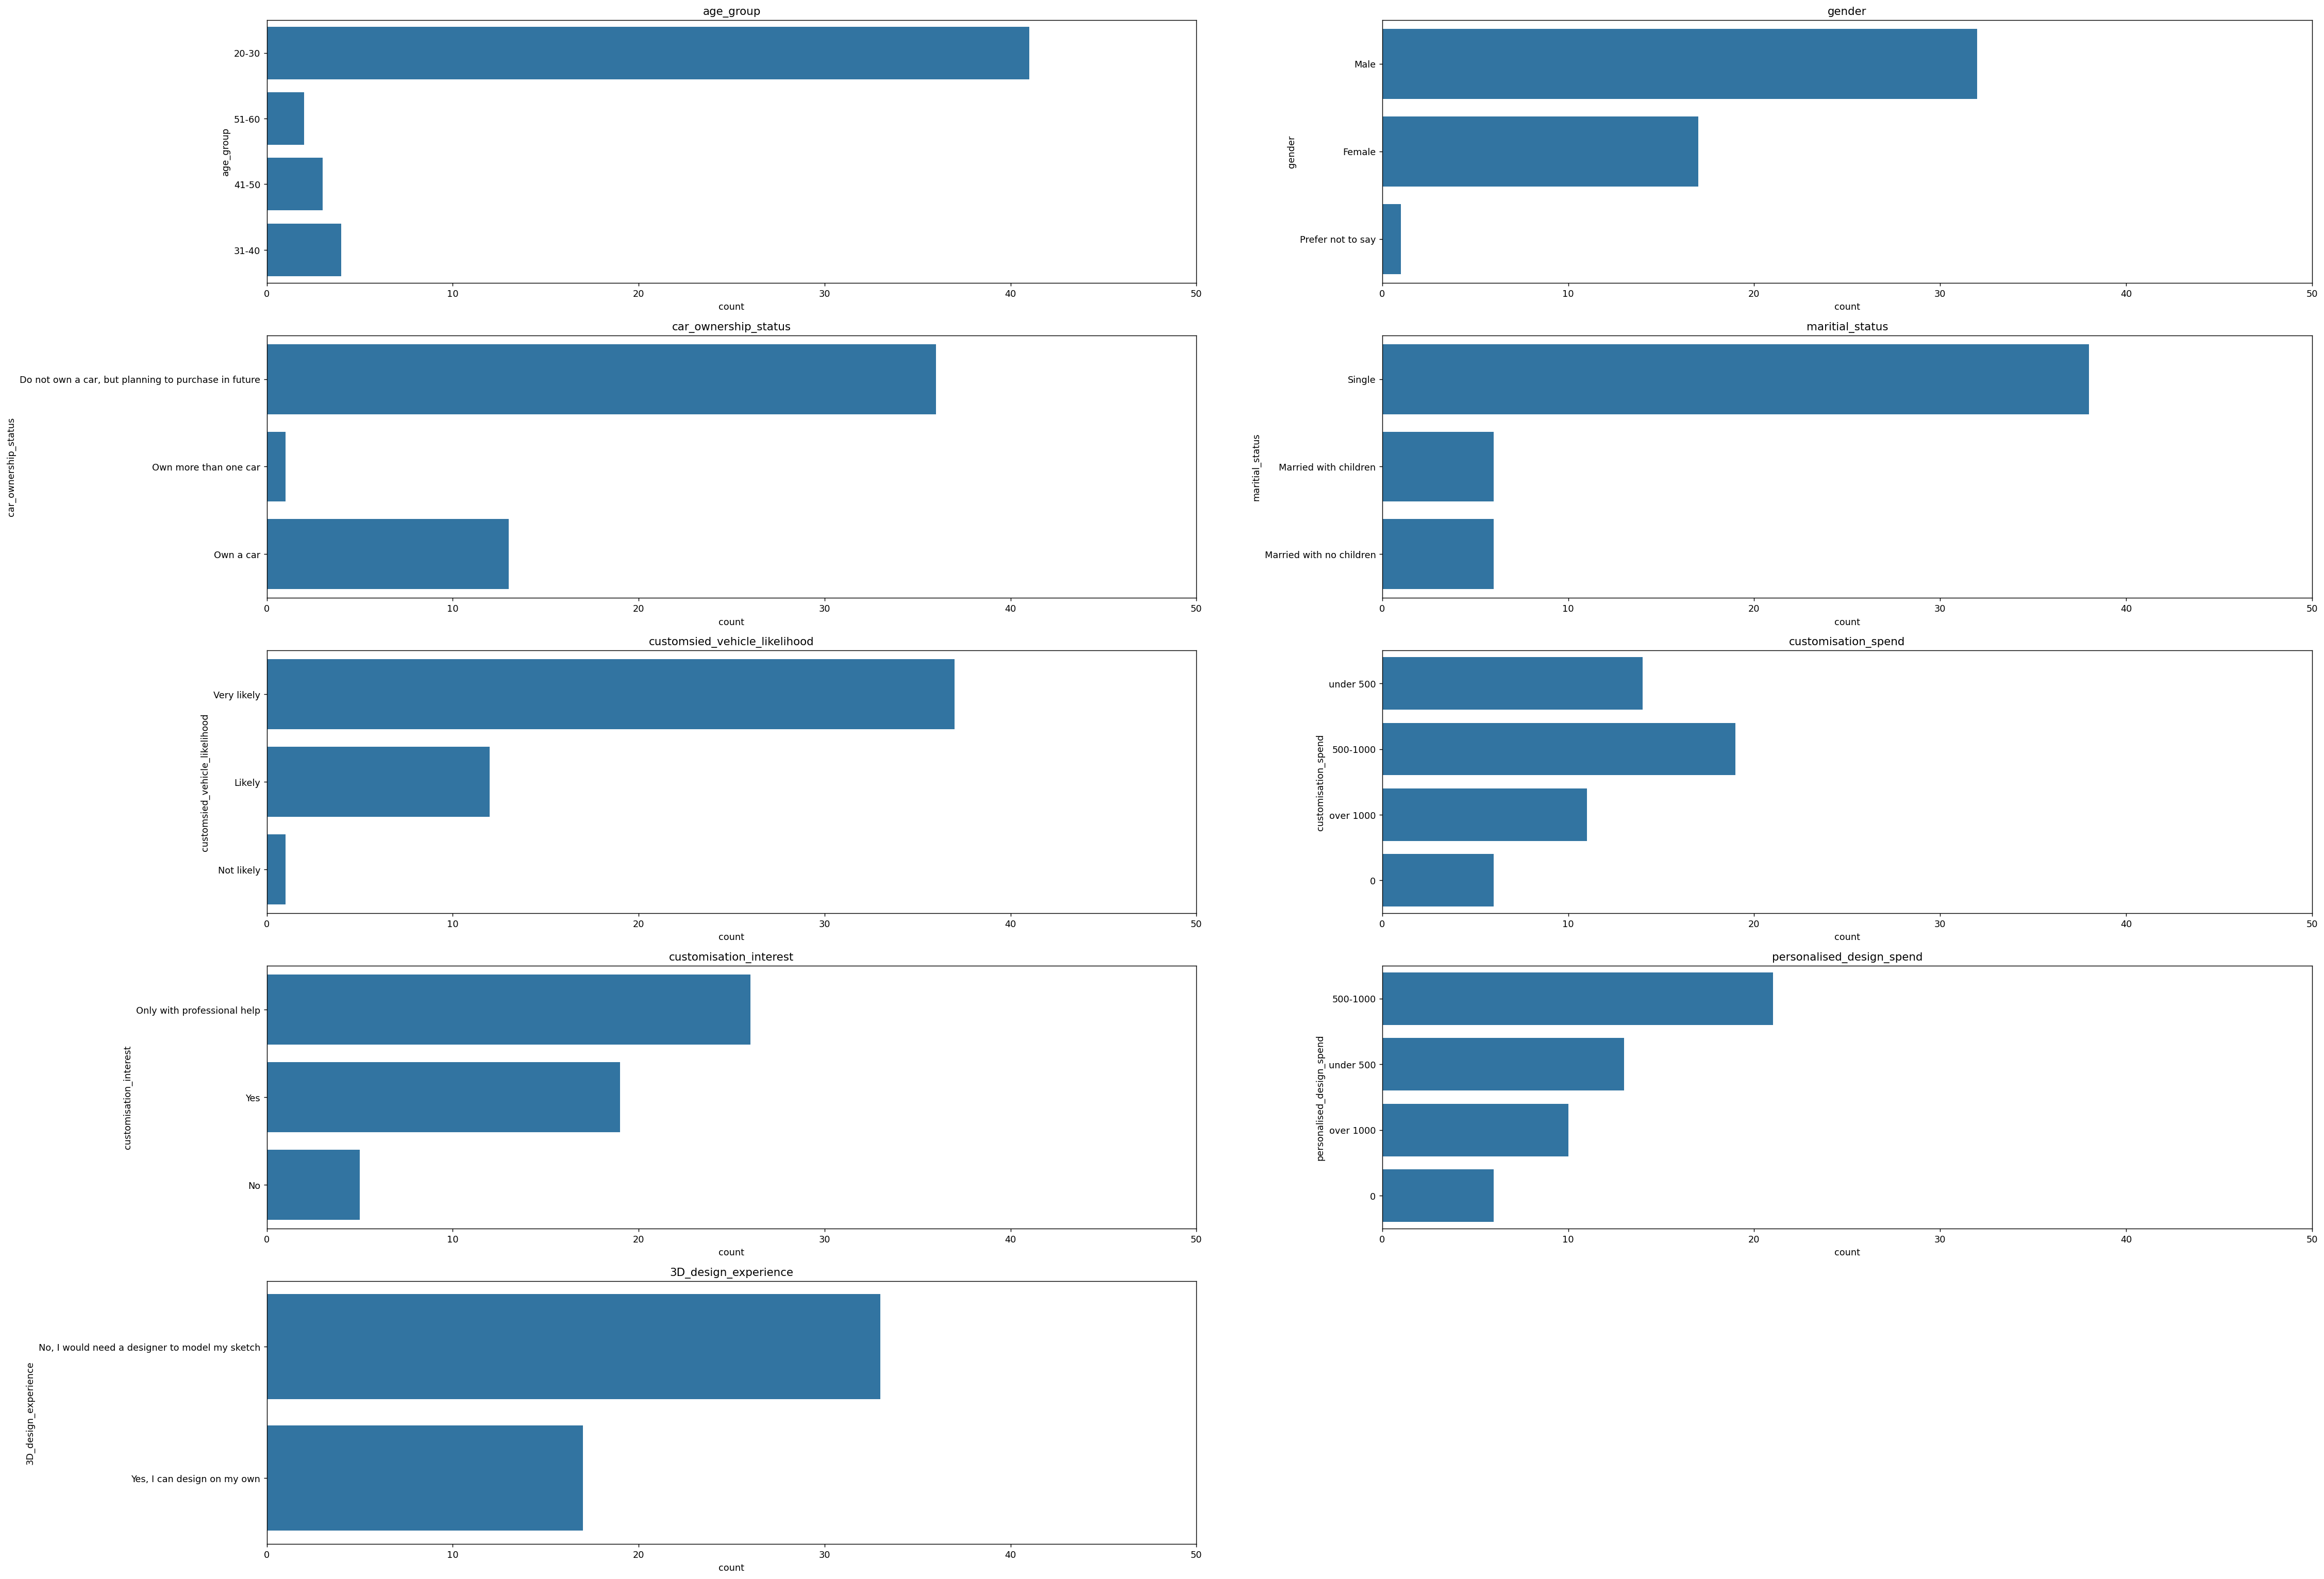

In [1268]:
column_names = ['age_group', 
                'gender', 
                'car_ownership_status', 
                'maritial_status', 
                'customsied_vehicle_likelihood', 
                'customisation_spend', 
                'customisation_interest', 
                'personalised_design_spend', 
                '3D_design_experience'
                ]
fig, ax = plt.subplots(dpi = 128, figsize=(40, 30))
plt.axis('off')
for i, col in enumerate(column_names):
  plt.subplot(5, 2, i+1)
  sns.countplot(data_mod_df[col])
  plt.title(col)
  plt.xlim(0,50)
plt.show()

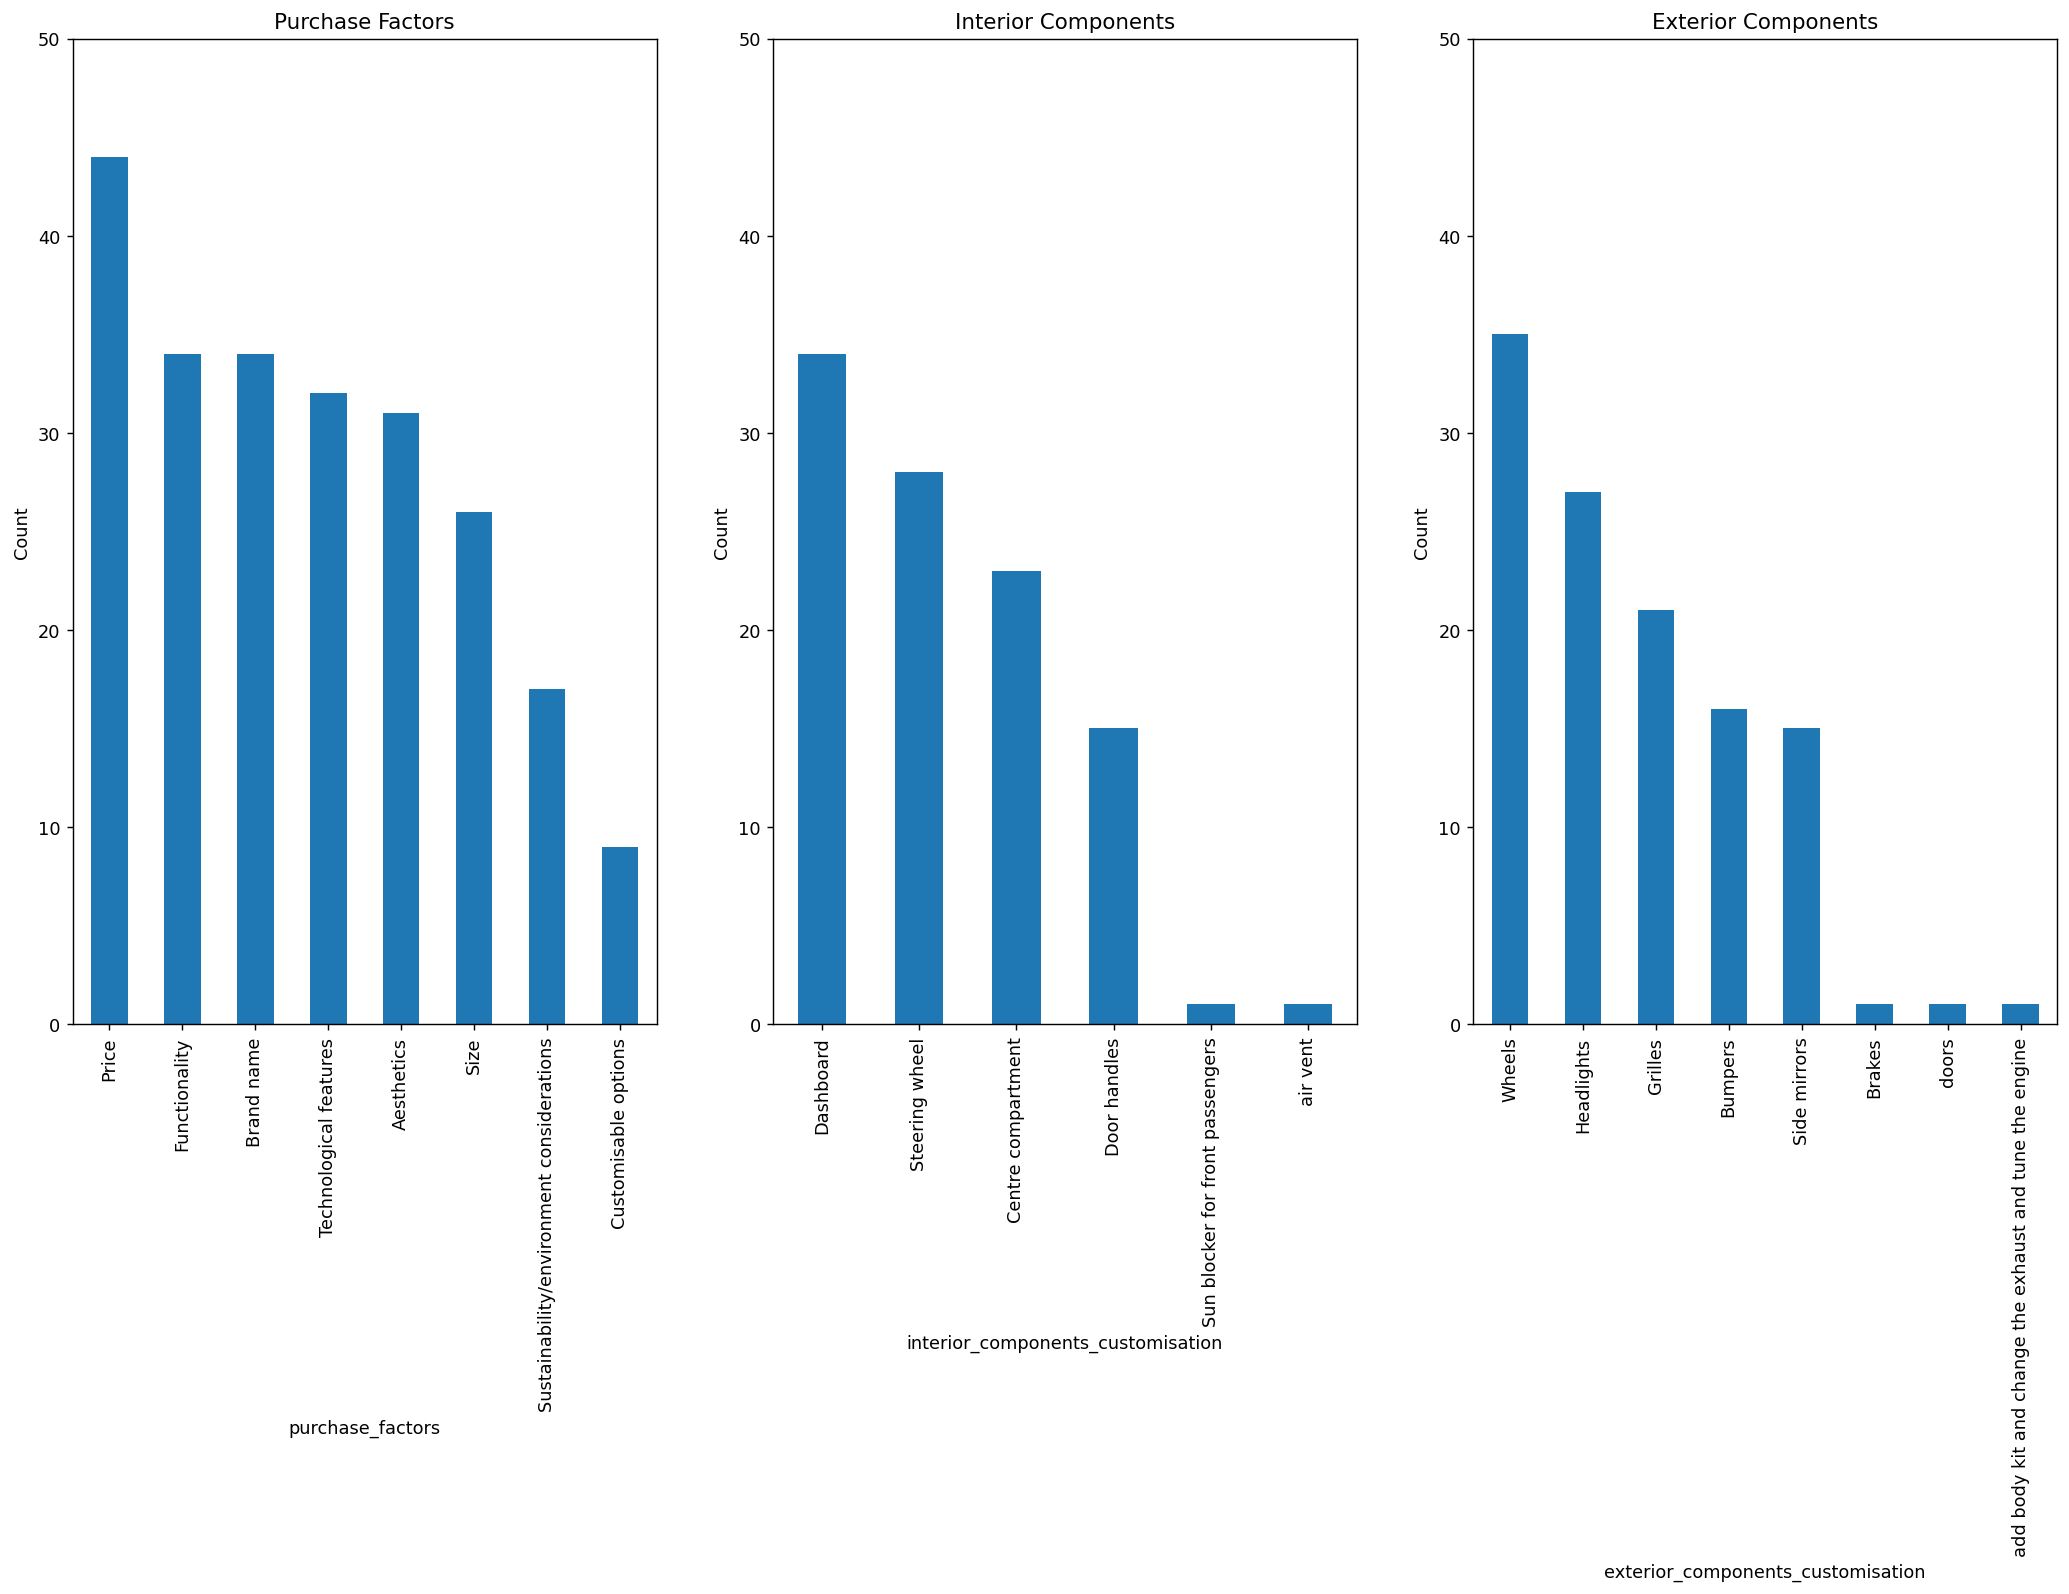

In [1269]:
fig, ax = plt.subplots(dpi = 128, figsize=(20, 10))
plt.axis('off')
plt.subplot(1, 3, 1)
plt.title("Purchase Factors")
plt.ylim(0, 50)
plt.ylabel("Count")
purchase_factor_counts.plot(kind='bar')
plt.subplot(1, 3, 2)
plt.title("Interior Components")
plt.ylim(0, 50)
plt.ylabel("Count")
interior_components_counts.plot(kind='bar')
plt.subplot(1, 3, 3)
plt.title("Exterior Components")
plt.ylim(0, 50)
plt.ylabel("Count")
exterior_components_counts.plot(kind='bar')
plt.show()

## Encoding Data


In [1270]:
from sklearn.preprocessing import LabelEncoder

In [1271]:
def encode_data_by_count(column_name, data_frame):
  print("_"*120)
  label_encoder = LabelEncoder()
  encoded_column_name = column_name+"_encoded"
  data_frame[encoded_column_name] = label_encoder.fit_transform(data_frame[column_name])
  legend = data_frame[[column_name, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)

def encode_by_label(df, unique_values, col):
  print("_"*120)
  encoded_column_name = col+"_encoded"
  for i, val in enumerate(unique_values):
    if val not in df[col].unique():
      print(f"'{val}' not in {col}")
      return
  label_mapping = {val: i for i, val in enumerate(unique_values)}
  df[encoded_column_name] = df[col].map(label_mapping)
  legend = df[[col, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)

In [1272]:
encode_by_label(data_mod_df, ['20-30', '31-40', '41-50', '51-60'],'age_group')
encode_by_label(data_mod_df, ['Do not own a car, but planning to purchase in future', 'Own a car', 'Own more than one car'], 'car_ownership_status')
encode_by_label(data_mod_df, ['Not likely', 'Likely', 'Very likely'], 'customsied_vehicle_likelihood')
encode_by_label(data_mod_df, ['0', 'under 500', '500-1000', 'over 1000'], 'customisation_spend')
encode_by_label(data_mod_df, ['No', 'Only with professional help', 'Yes'], 'customisation_interest')
encode_by_label(data_mod_df, ['0', 'under 500', '500-1000', 'over 1000'], 'personalised_design_spend')
encode_by_label(data_mod_df, ['No, I would need a designer to model my sketch', 'Yes, I can design on my own'], '3D_design_experience')

________________________________________________________________________________________________________________________
  age_group  age_group_encoded
0     20-30                  0
1     51-60                  3
2     41-50                  2
3     31-40                  1
________________________________________________________________________________________________________________________
                                car_ownership_status  \
0  Do not own a car, but planning to purchase in ...   
1                              Own more than one car   
2                                          Own a car   

   car_ownership_status_encoded  
0                             0  
1                             2  
2                             1  
________________________________________________________________________________________________________________________
  customsied_vehicle_likelihood  customsied_vehicle_likelihood_encoded
0                   Very likely                   

In [1273]:
encode_data_by_count('gender', data_mod_df)
encode_data_by_count('maritial_status', data_mod_df)

________________________________________________________________________________________________________________________
              gender  gender_encoded
0               Male               1
1             Female               0
2  Prefer not to say               2
________________________________________________________________________________________________________________________
            maritial_status  maritial_status_encoded
0                    Single                        2
1     Married with children                        0
2  Married with no children                        1


In [1274]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

print(fuzz.ratio("this is a test", "this is sdakf a test"))


82
